In [60]:
import deepdish as dd
import os
import numpy as np
import pylab as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import detectors, detector_psds

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=10, method='network', return_detected_dict=False):
    SNR_keys = [key for key in data_dict.keys() if 'SNR' in key]
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        dict_key = key.split('SNR_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0)]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

In [5]:
test_data_local = dd.io.load('../output_data/Test_data/1_day_prec_z_10_local_SNR_data.h5')['Optimal_SNR']

In [6]:
netw_labels = {'CE4020ET123':'CE4020, ET123',
               'CE40LIAsharpET123':'CE40, LI A#, ET123',
               'LHI_all_ASharp':'LHI @ A#',
               'LHV_design':'LHV design'}

In [58]:
def bin_style(hist_data):
    if len(hist_data)>100:
        bs = 'sqrt'
    else:
        if len(hist_data)>50:
            bs = 'auto'
        else:
            bs = len(hist_data)//3
            if bs==0:
                bs=1
    return(bs)

## BBH

In [51]:
data_dir_bbh = '../output_data/BBH/'

In [52]:
snr_data_bbh = {}
config_bbh = {}
for data_file in list(os.walk(data_dir_bbh))[0][2]:
    key = data_file.split('_PLP_')[0]
    bbh_data = dd.io.load(os.path.join(data_dir_bbh, data_file))
    snr_data_bbh[key] = bbh_data['Optimal_SNR']
    config_bbh[key] = bbh_data['config']

In [53]:
detected_bbh = {'all':{}, 'network':{}}
for key in snr_data_bbh.keys():
    detected_bbh['all'][key] = get_detected_SNRs(snr_data_bbh[key], method='all')
    detected_bbh['network'][key] = get_detected_SNRs(snr_data_bbh[key], method='network')

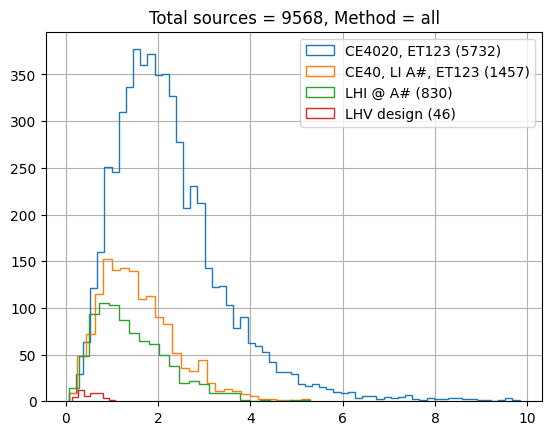

In [54]:
for key in detected_bbh['all'].keys():
    bbh_data = detected_bbh['all'][key]
    plt.hist(bbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bbh_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh["CE4020ET123"]["mass1"])}, Method = all')
plt.grid()

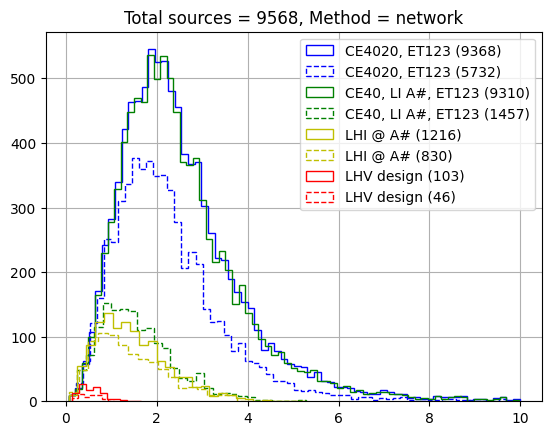

In [11]:
for key, colr in zip(detected_bbh['network'].keys(), ['b', 'g', 'y', 'r']):
    bbh_data = detected_bbh['network'][key]
    plt.hist(bbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bbh_data["redshift"])})', bins='auto', color=colr)
    bbh_data1 = detected_bbh['all'][key]
    plt.hist(bbh_data1['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bbh_data1["redshift"])})', bins='auto', ls='--', color=colr)
plt.legend()
plt.title(f'Total sources = {len(snr_data_bbh["CE4020ET123"]["mass1"])}, Method = network')
plt.grid()

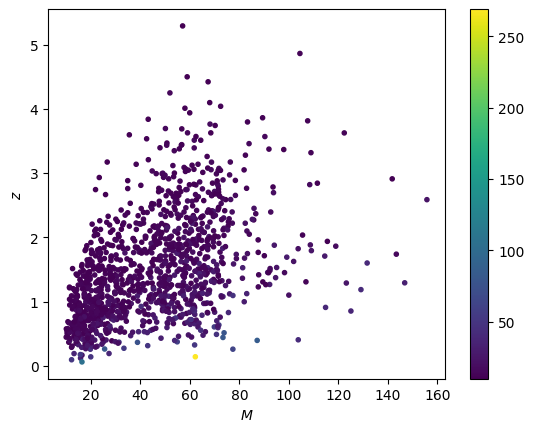

In [12]:
plt.scatter(detected_bbh['network']['LHI_all_ASharp']['srcmtotal'], 
            detected_bbh['network']['LHI_all_ASharp']['redshift'], 
            c=detected_bbh['network']['LHI_all_ASharp']['SNR_network'], marker='.')
plt.xlabel('$M$')
plt.ylabel('$z$')
plt.colorbar()

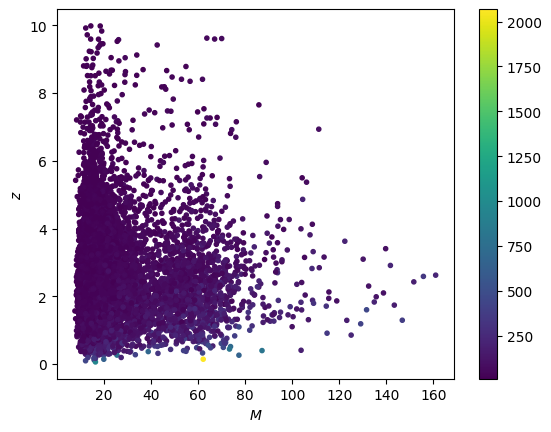

In [13]:
plt.scatter(detected_bbh['network']['CE4020ET123']['srcmtotal'], detected_bbh['network']['CE4020ET123']['redshift'], 
            c=detected_bbh['network']['CE4020ET123']['SNR_network'], marker='.')
plt.xlabel('$M$')
plt.ylabel('$z$')
plt.colorbar()

### Mass populations

In [14]:
def slice_mtotal_pop(arr, mtotal_range):
    """
    Returns: A bool array corresponding to arr, depending on the range provided
    """
    if '<' in mtotal_range:
        max_boundary = float(mtotal_range.split('<')[-1])
        return(arr < max_boundary)
        
    elif '<=' in mtotal_range:
        max_boundary = float(mtotal_range.split('<=')[-1])
        return(arr <= max_boundary)
        
    elif '>' in mtotal_range:
        min_boundary = float(mtotal_range.split('>')[-1])
        return(arr > min_boundary)
        
    elif '>=' in mtotal_range:
        min_boundary = float(mtotal_range.split('>=')[-1])
        return(arr >= min_boundary)
        
    elif '-' in mtotal_range:
        min_boundary, max_boundary = map(float, mtotal_range.split('-'))
        return(np.all((arr >= min_boundary, arr <= max_boundary), axis=0))

In [15]:
detect_type = 'network'
mass_pops_bbh = {}

for m_range in ['<10', '10-30', '30-70', '>70']:
    mass_pops_bbh[m_range] = {}
    for pop, input_dfs_dict in zip(['detected', 'total'], [detected_bbh[detect_type], snr_data_bbh]):
        mass_pops_bbh[m_range][pop] = {}
        for netw in input_dfs_dict.keys():
            bool_arr = slice_mtotal_pop(input_dfs_dict[netw]['srcmtotal'], m_range)
            mass_pops_bbh[m_range][pop][netw] = input_dfs_dict[netw][bool_arr]

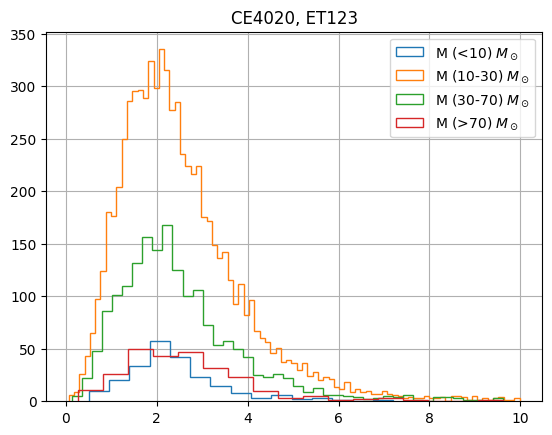

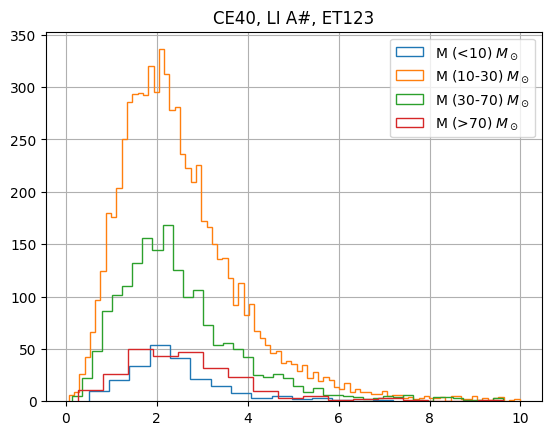

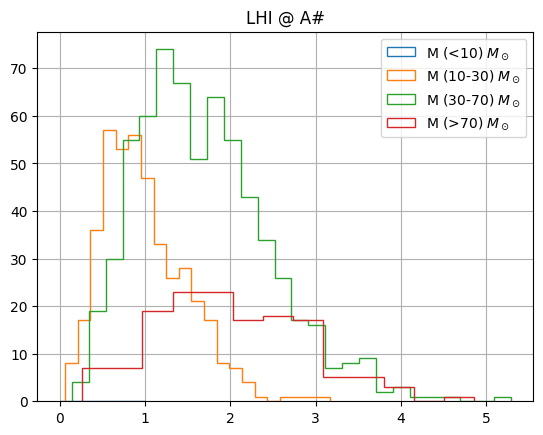

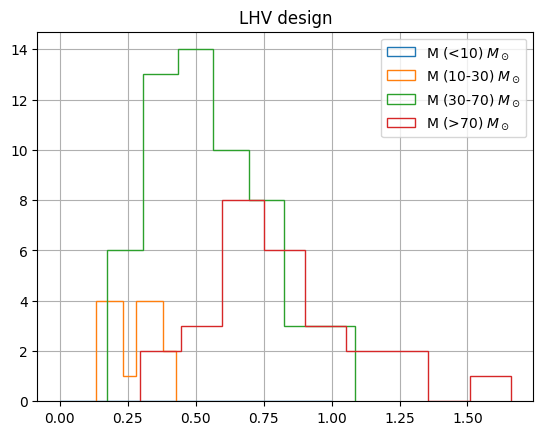

In [59]:
for netw in input_dfs_dict.keys():
    plt.figure()
    for m_range, color in zip(mass_pops_bbh.keys(), colors):
        hist_data = mass_pops_bbh[m_range]['detected'][netw]['redshift']
        plt.hist(hist_data, bins=bin_style(hist_data), histtype=u'step', label='M ('+m_range+') $M_\odot$', color=color);
    plt.title(netw_labels[netw])
    plt.legend()
    plt.grid()

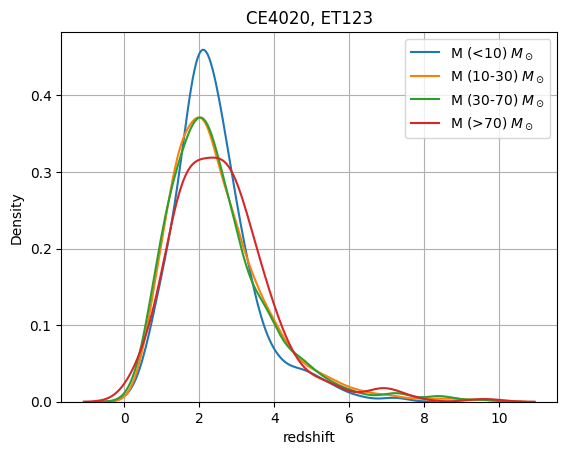

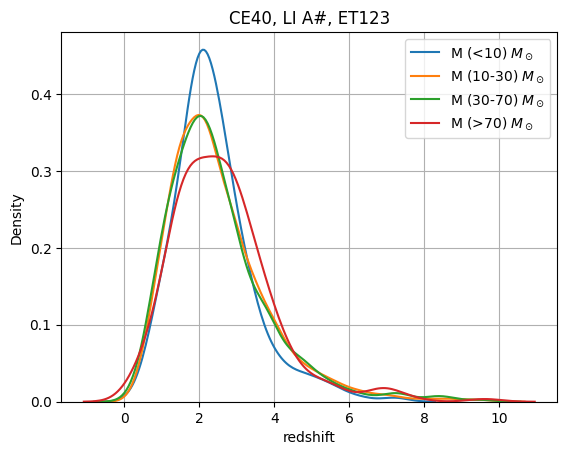

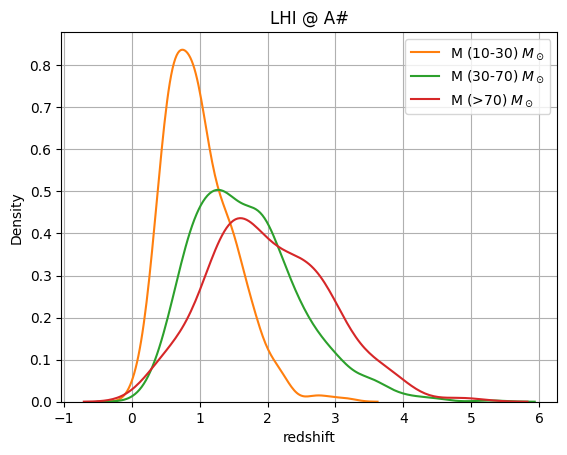

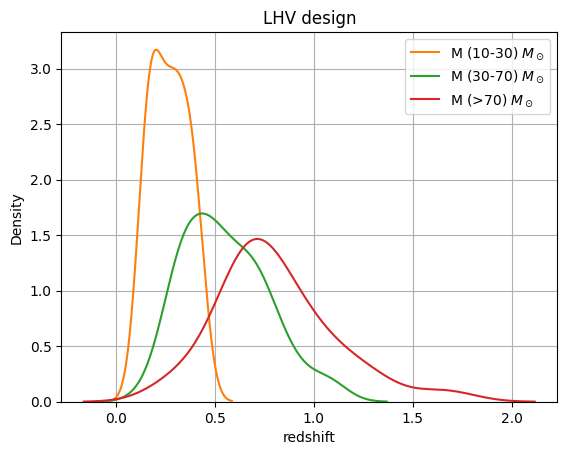

In [61]:
for netw in input_dfs_dict.keys():
    plt.figure()
    for m_range, color in zip(mass_pops_bbh.keys(), colors):
        hist_data = mass_pops_bbh[m_range]['detected'][netw]['redshift']
        sns.kdeplot(hist_data, label='M ('+m_range+') $M_\odot$', color=color);
    plt.title(netw_labels[netw])
    plt.legend()
    plt.grid()

## NSBH

In [64]:
data_dir_nsbh = '../output_data/NSBH/'

In [9]:
snr_data_nsbh = {}
config_nsbh = {}
for data_file in list(os.walk(data_dir_nsbh))[0][2]:
    key = data_file.split('_US_')[0]
    nsbh_data = dd.io.load(os.path.join(data_dir_nsbh, data_file))
    snr_data_nsbh[key] = nsbh_data['Optimal_SNR']
    config_nsbh[key] = nsbh_data['config']

In [10]:
detected_nsbh = {'all':{}, 'network':{}}
for key in snr_data_nsbh.keys():
    detected_nsbh['all'][key] = get_detected_SNRs(snr_data_nsbh[key], method='all')
    detected_nsbh['network'][key] = get_detected_SNRs(snr_data_nsbh[key], method='network')

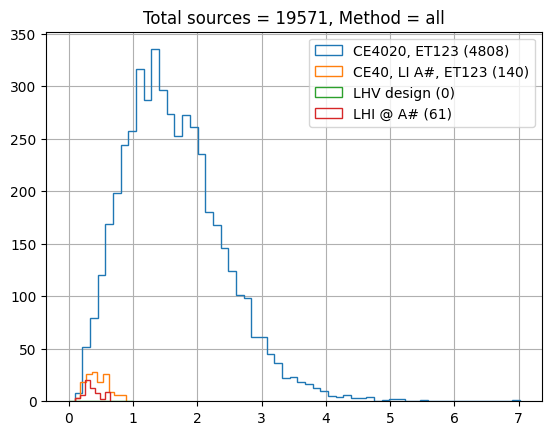

In [21]:
for key in detected_nsbh['all'].keys():
    nsbh_data = detected_nsbh['all'][key]
    plt.hist(nsbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(nsbh_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_nsbh["CE4020ET123"]["mass1"])}, Method = all')
plt.grid()

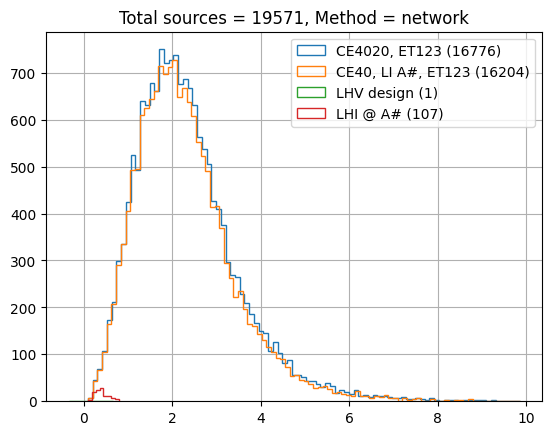

In [22]:
for key in detected_nsbh['network'].keys():
    nsbh_data = detected_nsbh['network'][key]
    plt.hist(nsbh_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(nsbh_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_nsbh["LHV_design"]["mass1"])}, Method = network')
plt.grid()

## BNS

In [65]:
data_dir_bns = '../output_data/BNS/'

In [66]:
snr_data_bns = {}
config_bns = {}
for data_file in list(os.walk(data_dir_bns))[0][2]:
    key = data_file.split('_DG_')[0]
    bns_data = dd.io.load(os.path.join(data_dir_bns, data_file))
    snr_data_bns[key] = bns_data['Optimal_SNR']
    config_bns[key] = bns_data['config']

In [67]:
detected_bns = {'all':{}, 'network':{}}
for key in snr_data_bns.keys():
    detected_bns['all'][key] = get_detected_SNRs(snr_data_bns[key], method='all')
    detected_bns['network'][key] = get_detected_SNRs(snr_data_bns[key], method='network')

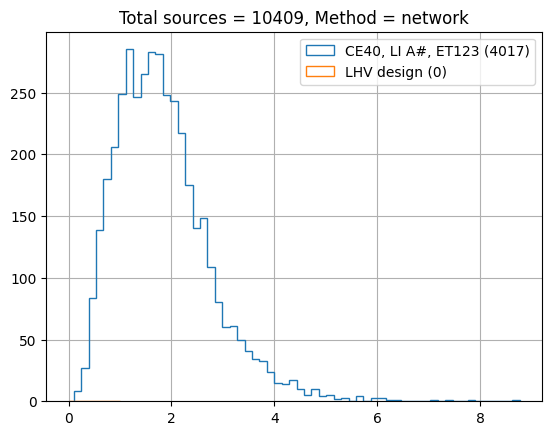

In [70]:
for key in detected_bns['network'].keys():
    bns_data = detected_bns['network'][key]
    plt.hist(bns_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bns_data["redshift"])})', bins='auto')
plt.legend()
plt.title(f'Total sources = {len(snr_data_bns["CE40LIAsharpET123"]["mass1"])}, Method = network')
plt.grid()

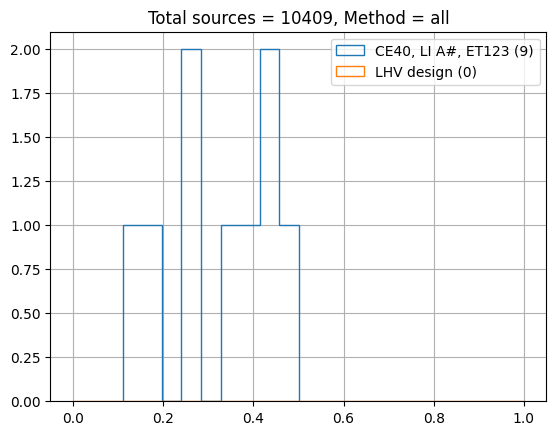

In [71]:
for key in detected_bns['all'].keys():
    bns_data = detected_bns['all'][key]
    plt.hist(bns_data['redshift'], histtype=u'step', 
             label=f'{netw_labels[key]} ({len(bns_data["redshift"])})', bins=9)
plt.legend()
plt.title(f'Total sources = {len(snr_data_bns["CE40LIAsharpET123"]["mass1"])}, Method = all')
plt.grid()